In [1]:
import pandas as pd
import json
import os
import ast # For safely evaluating string representations of lists
import matplotlib.pyplot as plt
import numpy as np
import re # For extracting threshold from folder name
from pathlib import Path

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For higher resolution plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors) # Use tab10 color palette

# --- Configuration ---
user = os.environ.get("USER", "default_user")
BASE_RESULTS_PATH = Path("/home/users/ntu/{user}/slimsc/prune/results".format(user=user))
BASE_PATH = f"{BASE_RESULTS_PATH}/R1-Distill-Qwen-14B/gpqa_diamond/" 

# Define the experiment sets
EXPERIMENT_SUBFOLDERS = [
    "diversity_n64_thresh0.92_delay20",
    "diversity_n64_thresh0.95_delay20",
    "diversity_n64_thresh0.98_delay20",
    "random_n64_thresh0.92_delay20",
    "random_n64_thresh0.95_delay20",
    "random_n64_thresh0.98_delay20",
]

BASELINE_SUBFOLDERS = [
    "sc_1_control",
    "sc_64_control"
]

# For parsing strategy and threshold
# Example: diversity_n64_thresh0.92_delay20 -> strategy=diversity, threshold=0.92
def parse_experiment_name(folder_name):
    strategy_match = re.search(r"^(diversity|random)_", folder_name)
    threshold_match = re.search(r"thresh(\d+\.\d+)", folder_name)
    
    strategy = strategy_match.group(1) if strategy_match else None
    threshold = float(threshold_match.group(1)) if threshold_match else None
    
    return strategy, threshold

# Function to check if correct answer is in candidates
def check_correct_in_candidates(row):
    try:
        candidates = ast.literal_eval(row['individual_answers_str'])
        return row['correct_answer'] in candidates
    except (ValueError, SyntaxError): # Handle malformed strings or empty lists if any
        return False

In [23]:
def load_experiment_metrics(exp_subfolder):
    """
    Loads metrics from a single experiment's evaluation_summary.csv and aggregated_metrics.json.
    Ensures numeric metrics are converted to float.
    """
    full_path = os.path.join(BASE_PATH, exp_subfolder)
    eval_summary_path = os.path.join(full_path, "evaluation_summary.csv")
    agg_metrics_path = os.path.join(full_path, "aggregated_metrics.json")

    metrics = {
        "folder": exp_subfolder,
        "accuracy": None,
        "pct_correct_in_candidates": None,
        "mean_completion_tokens": None,
        "mean_processing_time": None,
        "strategy": None,
        "threshold": None
    }

    # Helper to convert value to float, handling strings (incl. with 's') and None
    def to_float_or_none(val, field_name_for_warning="value"):
        if val is None:
            return None
        try:
            if isinstance(val, str):
                # Remove common non-numeric characters (like 's' from time, commas from tokens)
                # Allows only digits and a single decimal point.
                cleaned_val_str = re.sub(r"[^0-9.]", "", val)
                if not cleaned_val_str: # empty after cleaning
                    return None
                return float(cleaned_val_str)
            return float(val) # Directly convert if already int/float
        except (ValueError, TypeError):
            print(f"Warning: Could not convert {field_name_for_warning} '{val}' from {exp_subfolder} to float. Setting to None.")
            return None

    # --- From evaluation_summary.csv ---
    if os.path.exists(eval_summary_path):
        try:
            df_eval = pd.read_csv(eval_summary_path)
            if not df_eval.empty and 'final_score' in df_eval.columns:
                # Ensure final_score is numeric before mean
                df_eval['final_score'] = pd.to_numeric(df_eval['final_score'], errors='coerce')
                metrics["accuracy"] = to_float_or_none(df_eval['final_score'].mean(), "accuracy from eval_summary")
                
                df_eval['correct_in_candidates'] = df_eval.apply(check_correct_in_candidates, axis=1)
                # correct_in_candidates will be boolean, mean will convert True/False to 1/0
                metrics["pct_correct_in_candidates"] = to_float_or_none(df_eval['correct_in_candidates'].mean(), "pct_correct_in_candidates from eval_summary")
            elif df_eval.empty:
                print(f"Warning: {eval_summary_path} is empty.")
            else:
                print(f"Warning: 'final_score' column missing in {eval_summary_path}.")

        except Exception as e:
            print(f"Error reading or processing {eval_summary_path}: {e}")
    else:
        print(f"Warning: {eval_summary_path} not found.")

    # --- From aggregated_metrics.json ---
    if os.path.exists(agg_metrics_path):
        try:
            with open(agg_metrics_path, 'r') as f:
                agg_data = json.load(f)
            
            json_metrics_dict = agg_data.get("metrics", {})
            
            # If accuracy from aggregated_metrics.json is preferred, you can override it here:
            # accuracy_from_agg = json_metrics_dict.get("overall_accuracy")
            # if accuracy_from_agg is not None:
            #     metrics["accuracy"] = to_float_or_none(accuracy_from_agg, "overall_accuracy from agg_metrics")

            metrics["mean_completion_tokens"] = to_float_or_none(
                json_metrics_dict.get("mean_total_completion_tokens_per_question"),
                "mean_total_completion_tokens_per_question"
            ) / 1000
            metrics["mean_processing_time"] = to_float_or_none(
                json_metrics_dict.get("mean_processing_duration_sec_per_question"),
                "mean_processing_duration_sec_per_question"
            )
        except Exception as e:
            print(f"Error reading or processing {agg_metrics_path}: {e}")
    else:
        print(f"Warning: {agg_metrics_path} not found.")
        
    # Parse strategy and threshold for main experiments
    if exp_subfolder not in BASELINE_SUBFOLDERS: # Make sure BASELINE_SUBFOLDERS is defined (usually in Cell 1)
        strategy, threshold_val = parse_experiment_name(exp_subfolder) # Ensure parse_experiment_name is defined
        metrics["strategy"] = strategy
        metrics["threshold"] = to_float_or_none(threshold_val, "threshold") # Threshold should be float
    else: # For baselines
        metrics["strategy"] = exp_subfolder

    return metrics

In [24]:
all_metrics_data = []
for subfolder in EXPERIMENT_SUBFOLDERS:
    metrics = load_experiment_metrics(subfolder)
    if metrics["strategy"] and metrics["threshold"] is not None: # Ensure parsing was successful
        all_metrics_data.append(metrics)
    else:
        print(f"Could not parse strategy/threshold for {subfolder}, skipping.")

df_experiments = pd.DataFrame(all_metrics_data)
# Convert relevant columns to numeric, coercing errors if any metric was None
for col in ['accuracy', 'pct_correct_in_candidates', 'mean_completion_tokens', 'mean_processing_time', 'threshold']:
    if col in df_experiments.columns:
        df_experiments[col] = pd.to_numeric(df_experiments[col], errors='coerce')

print("--- Pruning Experiments Data ---")
print(df_experiments)

# Load baseline data
baseline_metrics_data = {}
for subfolder in BASELINE_SUBFOLDERS:
    metrics = load_experiment_metrics(subfolder)
    baseline_metrics_data[subfolder] = metrics

print("\n--- Baseline Data ---")
for name, data in baseline_metrics_data.items():
    print(f"{name}:")
    print(f"  Accuracy: {data['accuracy']:.4f}")
    print(f"  % Correct in Candidates: {data['pct_correct_in_candidates']:.4f}")
    print(f"  Mean Completion Tokens: {float(data['mean_completion_tokens']):.2f}")
    print(f"  Mean Processing Time: {float(data['mean_processing_time']):.2f}s")

--- Pruning Experiments Data ---
                             folder  accuracy  pct_correct_in_candidates  \
0  diversity_n64_thresh0.92_delay20  0.480000                   0.580000   
1  diversity_n64_thresh0.95_delay20  0.621212                   0.717172   
2  diversity_n64_thresh0.98_delay20  0.616162                   0.722222   
3     random_n64_thresh0.92_delay20  0.611111                   0.702020   
4     random_n64_thresh0.95_delay20  0.631313                   0.712121   
5     random_n64_thresh0.98_delay20  0.651515                   0.722222   

   mean_completion_tokens  mean_processing_time   strategy  threshold  
0              188.707720            176.094023  diversity       0.92  
1              200.499101            199.059972  diversity       0.95  
2              235.143838            227.986663  diversity       0.98  
3              191.623313            184.958314     random       0.92  
4              198.144621            198.818318     random       0.95  
5 

In [25]:
import matplotlib.ticker as mticker # For more control over ticks

def plot_comparison(df_exp, baseline_data, metric_key, y_label, title_prefix, lower_is_better=False):
    """
    Generates a double bar chart for a given metric, comparing diversity and random strategies,
    with dotted lines for baselines.
    Handles y-axis scaling and tick formatting for clarity.
    """
    
    # Prepare data for plotting
    strategies = df_exp['strategy'].unique()
    # Ensure strategies are always plotted in a consistent order if needed, e.g., random then diversity
    # For now, relies on order from df_exp['strategy'].unique() which could be ['diversity', 'random'] or vice-versa
    # If you want a fixed order:
    # strategies = sorted(list(df_exp['strategy'].unique()), key=lambda s: (s != 'random', s != 'diversity'))


    thresholds = sorted(df_exp['threshold'].unique())
    
    n_thresholds = len(thresholds)
    bar_width = 0.35  # Width of a single bar
    index = np.arange(n_thresholds) # x-positions for groups of bars

    fig, ax = plt.subplots(figsize=(5, 4)) # Increased figure size for better readability

    all_y_values_for_ylim = [] # To collect all values that will be plotted for y-limit calculation

    # Plot bars for each strategy
    for i, strategy in enumerate(strategies):
        strategy_data = df_exp[df_exp['strategy'] == strategy].set_index('threshold').reindex(thresholds)
        values = strategy_data[metric_key].values
        
        # Handle missing data for a threshold: replace NaN with 0 for bar plotting
        # (or np.nan if you want gaps, but 0 is usually fine if data truly missing)
        values_for_plotting = np.nan_to_num(values.astype(float), nan=0.0) 
        
        all_y_values_for_ylim.extend(values_for_plotting)
        
        # Calculate bar positions:
        # For two strategies, positions are index - bar_width/2 and index + bar_width/2
        # Generalizing for more strategies if needed: index + (i - (len(strategies)-1)/2) * bar_width
        if len(strategies) == 2:
            bar_pos = index + (i - 0.5) * bar_width
        else: # Fallback for 1 or >2 strategies, adjust as needed
            bar_pos = index + i * bar_width - ( (len(strategies)-1) * bar_width / 2)


        ax.bar(bar_pos, values_for_plotting, bar_width, label=f'{strategy.capitalize()} Pruning')

    # Add baseline lines and collect their values for y-limit calculation
    # Using labels from the user-provided image
    
    # Baseline CoT (sc_1_control)
    sc1_folder_key = "sc_1_control"
    if baseline_data.get(sc1_folder_key) and baseline_data[sc1_folder_key].get(metric_key) is not None:
        sc1_value = baseline_data[sc1_folder_key][metric_key]
        if sc1_value is not None and not np.isnan(sc1_value):
            ax.axhline(sc1_value, color='gray', linestyle=':', linewidth=2, label='CoT')
            all_y_values_for_ylim.append(sc1_value)
        else:
            print(f"Warning: Baseline CoT ({sc1_folder_key}) value for {metric_key} is None or NaN.")
            
    # Baseline SC N=64 (sc_64_control)
    sc64_folder_key = "sc_64_control"
    if baseline_data.get(sc64_folder_key) and baseline_data[sc64_folder_key].get(metric_key) is not None:
        sc64_value = baseline_data[sc64_folder_key][metric_key]
        if sc64_value is not None and not np.isnan(sc64_value):
            ax.axhline(sc64_value, color='black', linestyle='--', linewidth=2, label='SC N=64')
            all_y_values_for_ylim.append(sc64_value)
        else:
            print(f"Warning: Baseline SC N=64 ({sc64_folder_key}) value for {metric_key} is None or NaN.")

    # Determine y-axis limits
    # For metrics like tokens or time, y-axis should generally start at 0
    y_min_limit = 0
    
    valid_y_values = [v for v in all_y_values_for_ylim if v is not None and not np.isnan(v)]
    if not valid_y_values or max(valid_y_values) == 0 : # If all data is None, NaN, or 0
        y_max_limit = 1.0 # Default y_max if no actual data or all data is zero
    else:
        y_max_limit = max(valid_y_values)
    
    ax.set_ylim(bottom=y_min_limit, top=y_max_limit * 1.15 if y_max_limit > 0 else 1.0) # Add 15% padding at the top

    # Set labels and title
    ax.set_xlabel('Similarity Threshold', fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    
    # Set x-axis ticks and labels
    ax.set_xticks(index)
    ax.set_xticklabels([str(t) for t in thresholds], fontsize=11) # Ensure thresholds are strings for labels

    # Improve y-ticks appearance
    if y_max_limit > 0:
        ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=8, prune='upper')) # Aim for around 8 ticks
        # Format y-ticks as plain numbers (not scientific notation)
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useOffset=False))
        plt.ticklabel_format(style='plain', axis='y', useOffset=False)
    else: # Handle case where all data might be zero
        ax.set_yticks(np.linspace(0,1,5)) # Default ticks for 0-1 range

    ax.tick_params(axis='both', which='major', labelsize=11)

    # Add legend
    ax.legend(loc='lower right', fontsize=10) # Position legend like in the example image
    
    # Add grid (seaborn-whitegrid style is often good)
    # plt.style.use('seaborn-v0_8-whitegrid') # Uncomment to try a style
    ax.grid(True, linestyle='--', alpha=0.6, axis='y') # Keep grid for y-axis primarily

    fig.tight_layout() # Adjust plot to prevent labels from being cut off
    plt.show()

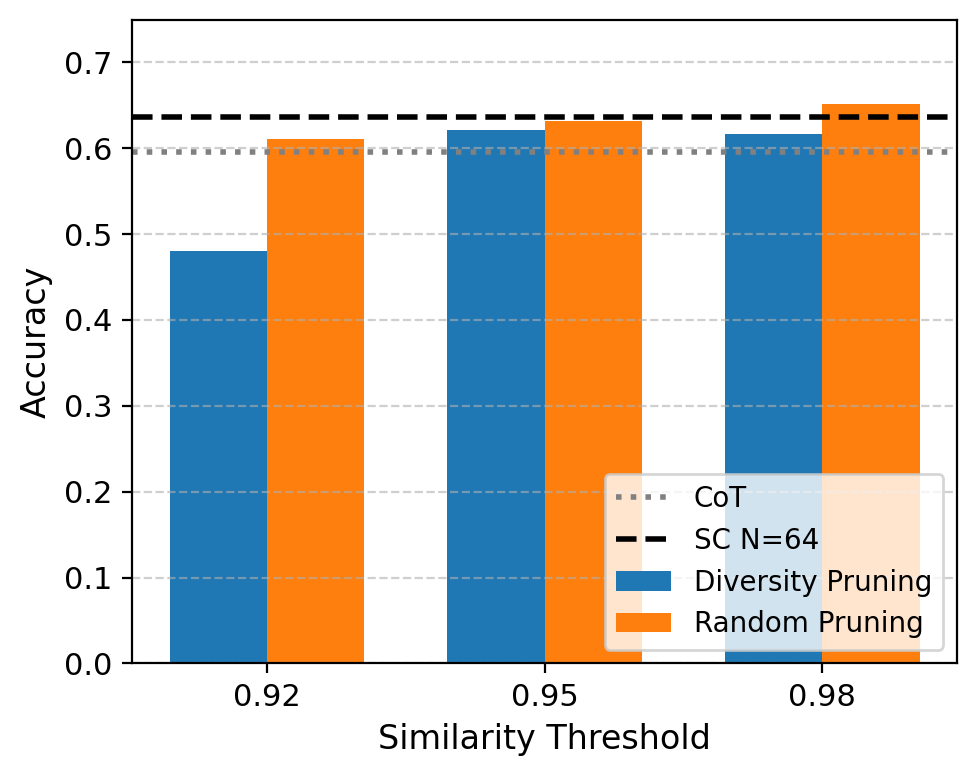

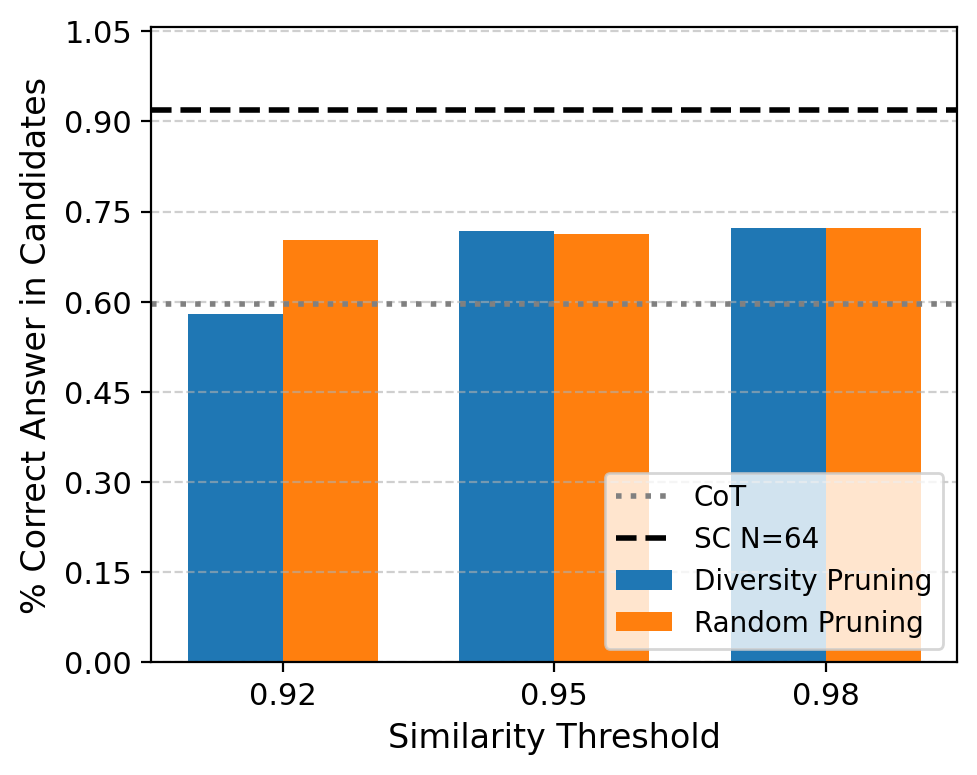

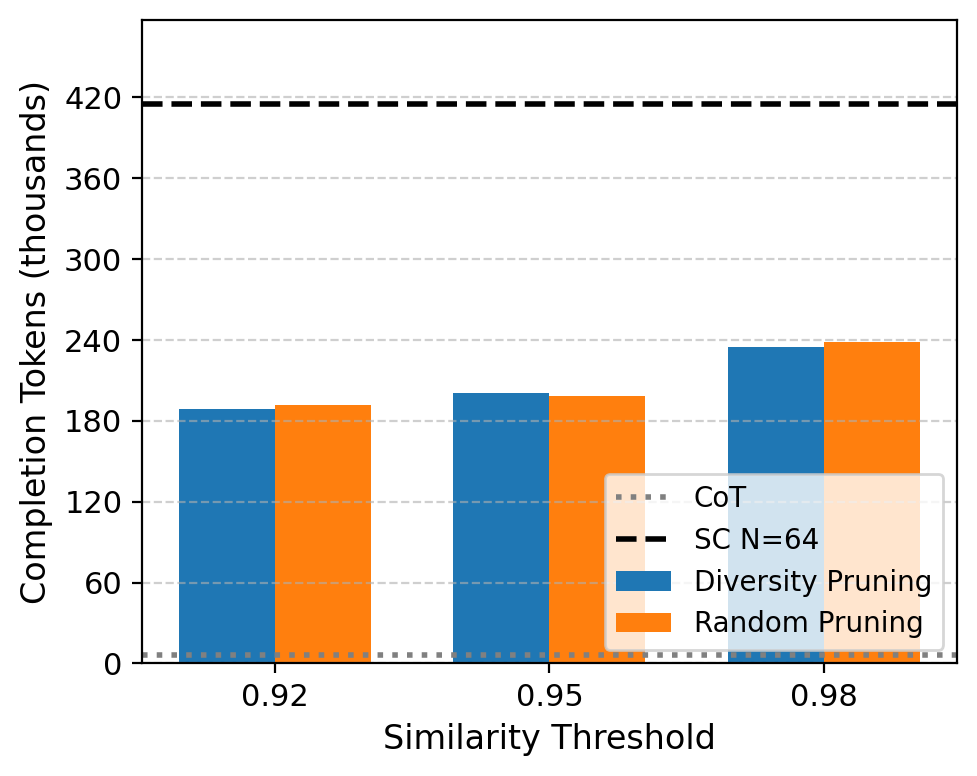

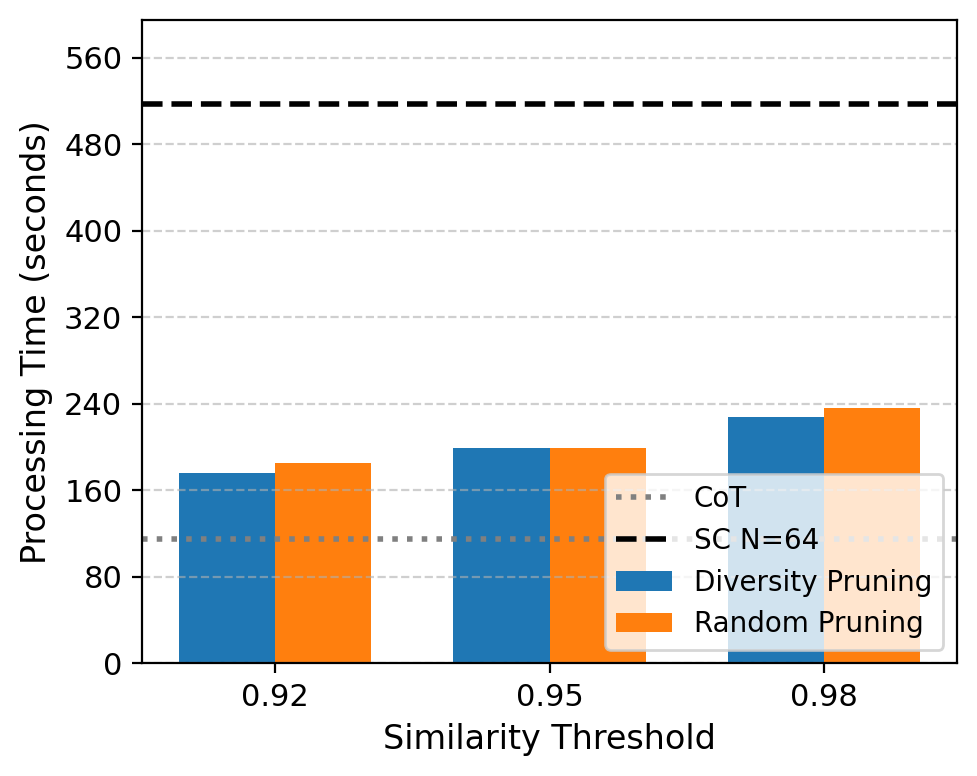

In [26]:
# Ensure df_experiments is not empty and has the required columns
if not df_experiments.empty and all(col in df_experiments.columns for col in ['strategy', 'threshold']):
    # Plot 1: Accuracy
    plot_comparison(
        df_experiments, 
        baseline_metrics_data, 
        'accuracy', 
        'Accuracy', 
        'Accuracy'
    )

    # Plot 2: % Correct Answer in Candidates
    plot_comparison(
        df_experiments, 
        baseline_metrics_data, 
        'pct_correct_in_candidates', 
        '% Correct Answer in Candidates', 
        'Recall of Correct Answer in Candidates'
    )

    # Plot 3: Mean Completion Tokens per Question
    plot_comparison(
        df_experiments, 
        baseline_metrics_data, 
        'mean_completion_tokens', 
        'Completion Tokens (thousands)', 
        'Resource Usage (Tokens)',
        lower_is_better=True
    )

    # Plot 4: Mean Processing Time per Question
    plot_comparison(
        df_experiments, 
        baseline_metrics_data, 
        'mean_processing_time', 
        'Processing Time (seconds)', 
        'Efficiency (Time)',
        lower_is_better=True
    )
else:
    print("DataFrame `df_experiments` is empty or missing required columns. Cannot generate plots.")
    print("Please check the data loading steps and file paths.")